In [ ]:
!pip install corus

In [2]:
import pandas as pd
import numpy as np
import random
from corus import load_lenta2
from tqdm import tqdm
np.random.seed(42)
random.seed(42)

In [ ]:
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_split_aspects.txt
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_split_reviews.txt

In [4]:
train_asp = pd.read_csv(
    'train_split_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_split_reviews.txt', delimiter='\t', names=['text_id','text'])

In [5]:
train_asp.head()

,text_id,category,mention,start,end,sentiment
0,30808,Whole,ресторане,16,25,neutral
1,30808,Interior,первом этаже,43,55,neutral
2,30808,Whole,руководству ресторана,124,145,positive
3,30808,Service,обслуживающему персоналу,147,171,positive
4,30808,Service,сотрудникам,189,200,positive


In [6]:
train_texts.head()

,text_id,text
0,25709,"Были 1 февраля. Я второй раз, подруга - первый..."
1,10099,Были в Дитае на прошлой неделе с подругой. Заш...
2,1105,Один из моих любимых ресторанов. С самого откр...
3,3647,Остались очень довольны. Хотим поблагодарить ш...
4,37070,приехали к друзьям в Питер из Москвы на Новый ...


In [7]:
from tqdm import tqdm
import re

Функция для создания окна в n слов вокруг упоминания аспекта в тексте отзыва:

In [8]:
def depunct(text):
    return re.sub("[^а-яёА-ЯЁ \-]", "", text)

In [9]:
def text_window(text, start, end, window=7, padding=True):
    after_text = depunct(text[end+1:])
    before_text = depunct(text[:start])
    end_text = ""
    start_text = ""
    if after_text:
        space_counter = 0
        i = 0
        while space_counter < window:
            end_text += after_text[i]
            if i == len(after_text) - 1:
                break
            i += 1
            if after_text[i] == " ":
                space_counter += 1

    if before_text:
        space_counter = 0
        i = -1
        while space_counter < window:
            start_text += before_text[i]
            if i == -len(before_text):
                break
            i -= 1
            if before_text[i] == " ":
                space_counter += 1
    
    end_tokens = end_text.strip().split()
    start_tokens = start_text[::-1].strip().split()
    if padding:
        while len(end_tokens) < window:
            end_tokens.append("PAD")
        while len(start_tokens) < window:
            start_tokens.insert(0, "PAD")
    return start_tokens, end_tokens

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/dev_reviews.txt
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/dev_aspects.txt

In [12]:
dev_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id', 'text'])

In [13]:
dev_aspects = pd.read_csv('dev_aspects.txt',
                          delimiter='\t',
                          names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment'])

In [14]:
dev_aspects.head()

,text_id,category,mention,start,end,sentiment
0,3976,Whole,ресторане,71,80,neutral
1,3976,Whole,ресторанах,198,208,neutral
2,3976,Whole,ресторане,256,265,neutral
3,3976,Service,Столик бронировали,267,285,neutral
4,3976,Service,администратор,322,335,positive


В качестве классификатора была выбрана логистическая регрессия, поскольку она показала лучшие результаты в сравнении с наивным байесом:
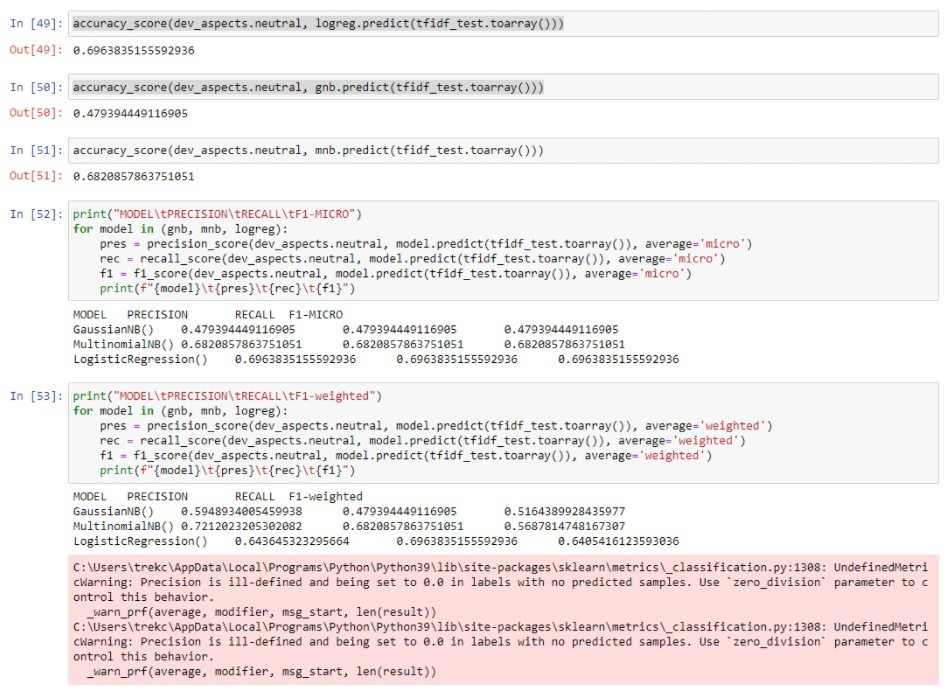

Посмотрим, какое окно лучше всего отобразится на accuracy и f1.

Для этого сравним между собой модели логистической регрессии, дав им окна разного размера.

Окна векторизуются при помощи TF-IDF. Странным образом, эмбеддинги этих окон при помощи BERT дали результаты хуже.

In [15]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

In [16]:
logreg_by_window = {}
y_train = train_asp["sentiment"]
for window_size in range(2, 10):
    aspect_windows = []
    for asp in tqdm(train_asp.values):
        text_id = asp[0]
        start = asp[3]
        end = asp[4]
        aspect_windows.append(text_window(list(train_texts[train_texts.text_id == text_id].text)[0], start, end, window_size))
    
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform([" ".join(windows[0]+windows[1]) for windows in aspect_windows])
    test_aspect_windows = []

    for asp in tqdm(dev_aspects.values):
        text_id = asp[0]
        start = asp[3]
        end = asp[4]
        test_aspect_windows.append(text_window(list(dev_texts[dev_texts.text_id == text_id].text)[0], start, end, window_size))
    tfidf_test = tfidf.transform([" ".join(windows[0]+windows[1]) for windows in test_aspect_windows])
    X_train = tfidf_matrix.toarray()
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    logreg_by_window[window_size] = [accuracy_score(dev_aspects.sentiment, logreg.predict(tfidf_test.toarray())),
                                     f1_score(dev_aspects.sentiment, logreg.predict(tfidf_test.toarray()), average="weighted")]

100%|██████████| 1190/1190 [00:00<00:00, 1195.81it/s]


In [17]:
logreg_by_window

{2: [0.6848739495798319, 0.6203125983361587],
 3: [0.6957983193277311, 0.6397988335827666],
 4: [0.7016806722689075, 0.6397050679018753],
 5: [0.7, 0.64201176660297],
 6: [0.7058823529411765, 0.6419335715610255],
 7: [0.7067226890756303, 0.6439199377529347],
 8: [0.7, 0.63312591990457],
 9: [0.6974789915966386, 0.630827102473007]}

Получаем оптимальный размер окна – 7, при котором максимальные accuracy и f1.

Построим эту модель еще раз.

In [ ]:
aspect_windows = []
for asp in tqdm(train_asp.values):
    text_id = asp[0]
    start = asp[3]
    end = asp[4]
    aspect_windows.append(text_window(list(train_texts[train_texts.text_id == text_id].text)[0], start, end, 7))

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform([" ".join(windows[0]+windows[1]) for windows in aspect_windows])
X_train = tfidf_matrix.toarray()

test_aspect_windows = []
for asp in tqdm(dev_aspects.values):
    text_id = asp[0]
    start = asp[3]
    end = asp[4]
    test_aspect_windows.append(text_window(list(dev_texts[dev_texts.text_id == text_id].text)[0], start, end, window_size))
tfidf_test = tfidf.transform([" ".join(windows[0]+windows[1]) for windows in test_aspect_windows])

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

100%|██████████| 1190/1190 [00:00<00:00, 1711.60it/s]


LogisticRegression()

Мы видим, что несмотря на то, что это лучшая модель, она все равно большинство отзывов считает positive.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


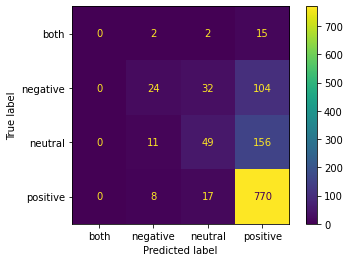

In [ ]:
plot_confusion_matrix(logreg, tfidf_test.toarray(), dev_aspects.sentiment)

Сделаем предсказания для размеченных нами аспектов.

In [ ]:
dev_aspects_predicted = pd.read_csv('dev_pred_aspects.txt',
                                    delimiter='\t',
                                    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment'])

In [ ]:
dev_aspects_predicted.head()

,text_id,category,mention,start,end,sentiment
0,785,Service,администратор,416,429,NaN
1,785,Service,помогла,392,399,NaN
2,785,Food,виды блюд,334,343,NaN
3,785,Food,Меню,176,180,NaN
4,785,Whole,Ресторан,69,77,NaN


In [ ]:
pred_aspect_windows = []
for asp in tqdm(dev_aspects_predicted.values):
    text_id = asp[0]
    start = asp[3]
    end = asp[4]
    pred_aspect_windows.append(text_window(list(dev_texts[dev_texts.text_id == text_id].text)[0], start, end, 7))
tfidf_test = tfidf.transform([" ".join(windows[0]+windows[1]) for windows in pred_aspect_windows])

100%|██████████| 951/951 [00:00<00:00, 1821.63it/s]


In [ ]:
dev_aspects_predicted["sentiment"] = logreg.predict(tfidf_test.toarray())

In [ ]:
dev_aspects_predicted.head()

,text_id,category,mention,start,end,sentiment
0,785,Service,администратор,416,429,positive
1,785,Service,помогла,392,399,positive
2,785,Food,виды блюд,334,343,negative
3,785,Food,Меню,176,180,positive
4,785,Whole,Ресторан,69,77,positive


Запишем:

In [ ]:
dev_aspects_predicted.to_csv("dev_pred_aspects_ours.txt", sep="\t", index=False, header=False)

# Обучение на всем трейне

Мы уже знаем какие модели лучше с чем справляются и получили разметку для получения evaluation-scores, поэтому, чтобы модели лучше работали на новых данных обучим их на всем трейне.

In [ ]:
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_aspects.txt
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_reviews.txt

In [19]:
asp_full = pd.read_csv(
    'train_split_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
texts_full = pd.read_csv('train_split_reviews.txt', delimiter='\t', names=['text_id','text'])

In [22]:
aspect_windows = []
y_train = asp_full["sentiment"]
for asp in tqdm(asp_full.values):
    text_id = asp[0]
    start = asp[3]
    end = asp[4]
    aspect_windows.append(text_window(list(texts_full[texts_full.text_id == text_id].text)[0], start, end, 7))

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform([" ".join(windows[0]+windows[1]) for windows in aspect_windows])
X_train = tfidf_matrix.toarray()

logreg_full = LogisticRegression()
logreg_full.fit(X_train, y_train)

100%|██████████| 3573/3573 [00:05<00:00, 703.47it/s]


LogisticRegression()

In [23]:
import pickle
filename = 'task2.sav'
pickle.dump(logreg_full, open(filename, 'wb'))